In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import graphviz
import re
import dtreeviz
from scipy.cluster import hierarchy as hc
import pickle

In [2]:
df = pd.read_csv('../data/TrainAndValid.csv', parse_dates=['saledate'], low_memory=False)
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

Trước tiên, chúng ta cần xử lý các cột thứ tự (ordinal columns). Đó là những cột chứa chuỗi nhưng có một thứ tự tự nhiên, ví dụ như nhỏ, trung bình và lớn.

In [5]:
miss_pct = df.isna().mean()
miss_pct

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
saledate                    0.000000
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
T

Những cột nào có nhiều hơn 90 phần trăm giá trị khuyết?

In [6]:
miss_pct[miss_pct > 0.9]

Blade_Extension      0.937041
Blade_Width          0.937041
Enclosure_Type       0.937041
Engine_Horsepower    0.937041
Pushblock            0.937041
Scarifier            0.937014
Tip_Control          0.937041
dtype: float64

In [7]:
cols_to_drop = miss_pct[miss_pct > 0.9].index.tolist()
df.drop(cols_to_drop, axis=1, inplace=True)

Trước tiên, chúng ta cần xử lý các cột thứ tự (ordinal columns). Đó là những cột chứa chuỗi nhưng có một thứ tự tự nhiên, ví dụ như nhỏ, trung bình và lớn.

In [8]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [9]:
df['UsageBand'].unique()

array(['Low', 'High', 'Medium', nan], dtype=object)

In [10]:
df['Hydraulics_Flow'].unique()

array([nan, 'Standard', 'High Flow', 'None or Unspecified'], dtype=object)

In [11]:
df['Grouser_Type'].unique()

array([nan, 'Double', 'Triple', 'Single'], dtype=object)

khá là bất ngờ là cột này không chứa giá trị công suất thực tế, cứ để nguyên cột này như vậy

In [12]:
df['Undercarriage_Pad_Width'].unique()

array([nan, 'None or Unspecified', '16 inch', '32 inch', '28 inch',
       '30 inch', '22 inch', '24 inch', '18 inch', '36 inch', '20 inch',
       '27 inch', '15 inch', '26 inch', '34 inch', '33 inch', '14 inch',
       '31 inch', '25 inch', '31.5 inch'], dtype=object)


`Undercarriage_Pad_Width` chứa các giá trị đo dạng số, có thể trích xuất ra các số và chuyển thành kiểu số.

`Blade_Width` cũng chứa các giá trị đo dạng số và có thể trích xuất, nhưng cần xử lý thêm trường hợp đặc biệt "<12".

In [13]:
df['Stick_Length'].unique()

array([nan, 'None or Unspecified', '11\' 0"', '15\' 9"', '10\' 2"',
       '10\' 6"', '9\' 10"', '10\' 10"', '9\' 6"', '9\' 7"', '12\' 8"',
       '8\' 2"', '8\' 6"', '9\' 8"', '12\' 10"', '11\' 10"', '8\' 10"',
       '8\' 4"', '12\' 4"', '9\' 5"', '6\' 3"', '14\' 1"', '13\' 7"',
       '13\' 10"', '13\' 9"', '7\' 10"', '15\' 4"', '9\' 2"', '24\' 3"',
       '19\' 8"'], dtype=object)

`Stick_Length` contains measurements in feet and inches

In [14]:
df['Tire_Size'].unique()

array(['None or Unspecified', '23.5', nan, '13"', '26.5', '29.5', '14"',
       '20.5', '17.5"', '15.5"', '20.5"', '17.5', '7.0"', '15.5', '23.5"',
       '10"', '23.1"', '10 inch'], dtype=object)

Cột `Tire_size` khá lộn xộn, có lẽ là do bộ dữ liệu này được gộp từ nhiều nguồn.

In [15]:
df['Undercarriage_Pad_Width'].value_counts(dropna=False)

Undercarriage_Pad_Width
NaN                    309782
None or Unspecified     82444
32 inch                  5287
28 inch                  3152
24 inch                  2998
20 inch                  2664
30 inch                  1602
36 inch                  1544
18 inch                  1439
34 inch                   540
16 inch                   481
31 inch                   191
27 inch                   144
22 inch                   135
26 inch                    98
33 inch                    94
14 inch                    51
15 inch                    33
25 inch                    17
31.5 inch                   2
Name: count, dtype: int64

Vậy "nan" và "None hoặc Unspecified" thực sự khác nhau. "nan" biểu thị rằng dữ liệu thực sự bị thiếu, không có gì được ghi lại, trong khi "None hoặc Unspecified" cho thấy có người đã ghi rõ rằng máy không có tính năng này hoặc thông số kỹ thuật của nó không được cung cấp.

In [16]:
df['Stick_Length'].value_counts(dropna=False)

Stick_Length
NaN                    310437
None or Unspecified     81539
9' 6"                    5832
10' 6"                   3519
11' 0"                   1601
9' 10"                   1463
9' 8"                    1462
9' 7"                    1423
12' 10"                  1087
10' 2"                   1004
8' 6"                     908
8' 2"                     614
10' 10"                   414
12' 8"                    322
11' 10"                   307
8' 4"                     274
8' 10"                    104
12' 4"                    103
9' 5"                     101
15' 9"                     87
6' 3"                      51
13' 7"                     11
14' 1"                      7
13' 10"                     7
13' 9"                      7
19' 8"                      5
7' 10"                      3
15' 4"                      3
24' 3"                      2
9' 2"                       1
Name: count, dtype: int64

In [17]:
df['Tire_Size'].value_counts(dropna=False)

Tire_Size
NaN                    315060
None or Unspecified     47823
20.5                    15773
14"                      9111
23.5                     8760
26.5                     4635
17.5                     3971
29.5                     2767
17.5"                    1815
13"                       776
20.5"                     737
15.5                      610
15.5"                     463
23.5"                     309
7.0"                       56
23.1"                      20
10"                         9
10 inch                     3
Name: count, dtype: int64

In [18]:
size_order = ['Mini', 'Compact', 'Small', 'Medium', 'Large / Medium', 'Large']
df['ProductSize'] = pd.Categorical(df['ProductSize'], categories=size_order, ordered=True)
df['ProductSize'].head(5)

0       NaN
1    Medium
2       NaN
3     Small
4       NaN
Name: ProductSize, dtype: category
Categories (6, object): ['Mini' < 'Compact' < 'Small' < 'Medium' < 'Large / Medium' < 'Large']

In [19]:
usage_order = ['Low', 'Medium', 'High']
df['UsageBand'] = pd.Categorical(df['UsageBand'], categories=usage_order, ordered=True)

In [20]:
flow_order = ['None or Unspecified', 'Standard', 'High Flow']
df['Hydraulics_Flow'] = pd.Categorical(df['Hydraulics_Flow'], categories=flow_order, ordered=True)
df['Hydraulics_Flow'].head(5)

0         NaN
1         NaN
2    Standard
3         NaN
4    Standard
Name: Hydraulics_Flow, dtype: category
Categories (3, object): ['None or Unspecified' < 'Standard' < 'High Flow']

In [21]:
grouser_order = ['Double', 'Triple', 'Single']
df['Grouser_Type'] = pd.Categorical(df['Grouser_Type'], categories=grouser_order, ordered=True)
df['Grouser_Type'].head(5)

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: Grouser_Type, dtype: category
Categories (3, object): ['Double' < 'Triple' < 'Single']

Vậy để phân biệt giữa `nan` và `None hoặc Unspecified`, ta sẽ điền giá trị `nan` là `-2` và `None hoặc Unspecified` là `-1`.

In [22]:
def extract_pad_width(x):
    if pd.isna(x): return -2
    if x == 'None or Unspecified': return -1
    return float(x.split(' ')[0])

In [23]:
df['Undercarriage_Pad_Width_num'] = df['Undercarriage_Pad_Width'].apply(extract_pad_width)
df['Undercarriage_Pad_Width_num'].head()

0   -2.0
1   -2.0
2   -2.0
3   -2.0
4   -2.0
Name: Undercarriage_Pad_Width_num, dtype: float64

In [24]:
def extract_stick_length(x):
    if pd.isna(x): return -2
    if x == 'None or Unspecified': return -1
    parts = x.replace('"', '').split("' ")
    feet = float(parts[0])
    inches = float(parts[1]) if len(parts) > 1 else 0
    return feet * 12 + inches # convert to total inches

In [25]:
df['Stick_Length_inches'] = df['Stick_Length'].apply(extract_stick_length)
df['Stick_Length_inches'].head()

0   -2.0
1   -2.0
2   -2.0
3   -2.0
4   -2.0
Name: Stick_Length_inches, dtype: float64

In [26]:
def extract_tire_size(x):
    if pd.isna(x): return -2
    if x == 'None or Unspecified': return -1
    if 'inch' in x: return float(x.split(' ')[0])
    return float(x.replace('"', ''))

In [27]:
df['Tire_Size_num'] = df['Tire_Size'].apply(extract_tire_size)
df['Tire_Size_num'].head()

0    -1.0
1    23.5
2    -2.0
3    -2.0
4    -2.0
Name: Tire_Size_num, dtype: float64

In [28]:
original_cols_to_drop = ['Stick_Length', 'Undercarriage_Pad_Width', 'Tire_Size']
df.drop(original_cols_to_drop, axis=1, inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   SalesID                      412698 non-null  int64         
 1   SalePrice                    412698 non-null  float64       
 2   MachineID                    412698 non-null  int64         
 3   ModelID                      412698 non-null  int64         
 4   datasource                   412698 non-null  int64         
 5   auctioneerID                 392562 non-null  float64       
 6   YearMade                     412698 non-null  int64         
 7   MachineHoursCurrentMeter     147504 non-null  float64       
 8   UsageBand                    73670 non-null   category      
 9   saledate                     412698 non-null  datetime64[ns]
 10  fiModelDesc                  412698 non-null  object        
 11  fiBaseModel               

In [30]:
idx = df['YearMade'] > df['saledate'].dt.year
df[idx]

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,Undercarriage_Pad_Width_num,Stick_Length_inches,Tire_Size_num
27786,1256766,27000.0,1424836,3247,132,2.0,1997,NaN,NaN,1996-12-13,...,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,-2.0
81843,1380049,29000.0,1189094,3538,132,1.0,2000,NaN,NaN,1999-10-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,-2.0,-2.0
161311,1582210,60000.0,1482307,28842,132,1.0,2006,NaN,NaN,2005-02-15,...,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,-2.0
176543,1607397,72000.0,1104056,4753,132,11.0,1998,NaN,NaN,1997-05-29,...,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,-2.0,-2.0,-1.0
206920,1656135,26500.0,1229496,8559,132,1.0,1998,NaN,NaN,1996-02-21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,-2.0,-1.0
209191,1662009,8500.0,1481256,14755,132,2.0,2008,NaN,NaN,2001-10-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,-2.0,-2.0
213253,1672382,12000.0,1151751,4988,132,4.0,2008,NaN,NaN,1996-02-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,-2.0,-2.0
231762,1725834,22500.0,1106818,8954,132,1.0,2006,NaN,NaN,1996-07-16,...,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,-2.0
242681,1748962,27000.0,1361981,257,132,6.0,2008,NaN,NaN,1997-12-15,...,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,-2.0,-2.0,-2.0
251546,1766755,100000.0,1241578,457,132,6.0,2002,NaN,NaN,1995-08-11,...,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,-1.0,126.0,-2.0


Như đã thảo luận trong notebook EDA, chúng ta sẽ điền giá trị này bằng cùng ngày thuộc năm của trường `saledate`.

In [31]:
df.loc[idx, 'YearMade'] = df.loc[idx, 'saledate'].dt.year

In [32]:
df['YearMade'].unique().min()

np.int64(1000)

tương tự với `YearMade` = 1000 nó là giá trị mặc định cho giá trị khuyết như đã thảo luận ở EDA notebook, chúng ta sẽ điền nó với 1950

In [33]:
df.loc[df['YearMade'] < 1900, 'YearMade'] = 1950

### handling date

vì chúng ta sẽ sử dụng mô hình dựa trên cây, về cơ bản nó sẽ chia nhóm thành hai phần, nên khi xử lý kiểu dữ liệu ngày tháng, chúng ta nên coi nó giống như kiểu dữ liệu thứ tự (ordinal), vì ngày tháng cũng có thứ tự tự nhiên (một ngày lớn hơn ngày khác). Tuy nhiên, ngày tháng có một điểm khác biệt vì một số ngày có thể liên quan đến các sự kiện đặc biệt, điều này có thể ảnh hưởng đáng kể đến giá bán, chẳng hạn như ngày đó có chương trình giảm giá, là ngày lễ, hoặc trùng với các sự kiện lớn hay chương trình khuyến mãi. Vì vậy, chúng ta muốn mô hình của mình hiểu nhiều hơn là chỉ biết một ngày gần đây hơn hay xa hơn ngày khác

In [34]:
df['saleYear'] = df['saledate'].dt.year
df['saleMonth'] = df['saledate'].dt.month
df['saleDay'] = df['saledate'].dt.day
df['saleWeek'] = df['saledate'].dt.isocalendar().week
df['saleDayofweek'] = df['saledate'].dt.dayofweek
df['saleDayofyear'] = df['saledate'].dt.dayofyear

In [35]:
df['saleIs_month_end'] = df['saledate'].dt.is_month_end.astype(int)
df['saleIs_month_start'] = df['saledate'].dt.is_month_start.astype(int)
df['saleIs_quarter_end'] = df['saledate'].dt.is_quarter_end.astype(int)
df['saleIs_quarter_start'] = df['saledate'].dt.is_quarter_start.astype(int)
df['saleIs_year_end'] = df['saledate'].dt.is_year_end.astype(int)
df['saleIs_year_start'] = df['saledate'].dt.is_year_start.astype(int)

In [36]:
min_date = df['saledate'].min()
df['saleElapsed'] = (df['saledate'] - min_date).dt.days

In [37]:
date_cols = [col for col in df.columns if col.startswith('sale') and col != 'saledate' and col != 'saleprice']
df[date_cols].head()

,saleYear,saleMonth,saleDay,saleWeek,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,2006,11,16,46,3,320,0,0,0,0,0,0,6512
1,2004,3,26,13,4,86,0,0,0,0,0,0,5547
2,2004,2,26,9,3,57,0,0,0,0,0,0,5518
3,2011,5,19,20,3,139,0,0,0,0,0,0,8157
4,2009,7,23,30,3,204,0,0,0,0,0,0,7492


In [38]:
df.drop('saledate', axis=1, inplace=True)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 58 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SalesID                      412698 non-null  int64   
 1   SalePrice                    412698 non-null  float64 
 2   MachineID                    412698 non-null  int64   
 3   ModelID                      412698 non-null  int64   
 4   datasource                   412698 non-null  int64   
 5   auctioneerID                 392562 non-null  float64 
 6   YearMade                     412698 non-null  int64   
 7   MachineHoursCurrentMeter     147504 non-null  float64 
 8   UsageBand                    73670 non-null   category
 9   fiModelDesc                  412698 non-null  object  
 10  fiBaseModel                  412698 non-null  object  
 11  fiSecondaryDesc              271971 non-null  object  
 12  fiModelSeries                58667 non-null 

In [40]:
num_mis = []
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum(): num_mis.append(label)
num_mis

['auctioneerID', 'MachineHoursCurrentMeter']

In [41]:
df[num_mis].isna().sum()

auctioneerID                 20136
MachineHoursCurrentMeter    265194
dtype: int64

Đầu tiên, `auctioneerID` là một cột dạng số, nhưng thực ra nó là một cột dạng phân loại (categorical). Vì vậy, ta nên điền giá trị thiếu bằng mode của cột.

In [42]:
auctioneer_id_mode = df['auctioneerID'].mode()[0]
df.fillna({'auctioneerID': auctioneer_id_mode}, inplace=True)

Cột `MachineHoursCurrentMeter` có hơn 64% giá trị thiếu. Vì đây là một cột dạng số và hầu hết các máy đều có số giờ hoạt động bằng 0, nên ta sẽ điền giá trị thiếu bằng 0 và thêm một cột chỉ báo để đánh dấu các giá trị bị thiếu.

In [43]:
df['has_MachineHours'] = (~df['MachineHoursCurrentMeter'].isna()).astype(int)
df.fillna({'MachineHoursCurrentMeter': 0}, inplace=True)

In [44]:
df[num_mis].isna().sum()

auctioneerID                0
MachineHoursCurrentMeter    0
dtype: int64

drop redundant columns

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 59 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SalesID                      412698 non-null  int64   
 1   SalePrice                    412698 non-null  float64 
 2   MachineID                    412698 non-null  int64   
 3   ModelID                      412698 non-null  int64   
 4   datasource                   412698 non-null  int64   
 5   auctioneerID                 412698 non-null  float64 
 6   YearMade                     412698 non-null  int64   
 7   MachineHoursCurrentMeter     412698 non-null  float64 
 8   UsageBand                    73670 non-null   category
 9   fiModelDesc                  412698 non-null  object  
 10  fiBaseModel                  412698 non-null  object  
 11  fiSecondaryDesc              271971 non-null  object  
 12  fiModelSeries                58667 non-null 

In [46]:
obj_cols = df.select_dtypes(include=['object']).columns.to_list()
obj_cols

['fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Hydraulics',
 'Ripper',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Track_Type',
 'Thumb',
 'Pattern_Changer',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls']

In [47]:
df[obj_cols].isna().sum()

fiModelDesc                0
fiBaseModel                0
fiSecondaryDesc       140727
fiModelSeries         354031
fiModelDescriptor     337882
fiProductClassDesc         0
state                      0
ProductGroup               0
ProductGroupDesc           0
Drive_System          305611
Enclosure                334
Forks                 214983
Pad_Type              331602
Ride_Control          259970
Stick                 331602
Transmission          224691
Turbocharged          331602
Hydraulics             82565
Ripper                305753
Coupler               192019
Coupler_System        367724
Grouser_Tracks        367823
Track_Type            310505
Thumb                 310366
Pattern_Changer       310437
Backhoe_Mounting      331986
Blade_Type            330823
Travel_Controls       330821
Differential_Type     341134
Steering_Controls     341176
dtype: int64

Vì `Enclosure` và `Hydraulics` có tỷ lệ giá trị thiếu thấp, nên ta sẽ điền giá trị thiếu bằng mode và thêm các cột `hasEnclosure`, `hasHydraulics` làm cột chỉ báo.

In [48]:
for col in ['Enclosure', 'Hydraulics']:
    mode_val = df[col].mode()[0]
    df[f'has_{col}'] = (~df[col].isna()).astype(int)
    df.fillna({col: mode_val}, inplace=True)

In [49]:
for col in obj_cols:
    df[col] = pd.Categorical(df[col])

In [50]:
cat_cols  = df.select_dtypes(include=['category']).columns.to_list()
for col in cat_cols:
    df[col] = df[col].cat.codes + 1

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 61 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SalesID                      412698 non-null  int64  
 1   SalePrice                    412698 non-null  float64
 2   MachineID                    412698 non-null  int64  
 3   ModelID                      412698 non-null  int64  
 4   datasource                   412698 non-null  int64  
 5   auctioneerID                 412698 non-null  float64
 6   YearMade                     412698 non-null  int64  
 7   MachineHoursCurrentMeter     412698 non-null  float64
 8   UsageBand                    412698 non-null  int8   
 9   fiModelDesc                  412698 non-null  int16  
 10  fiBaseModel                  412698 non-null  int16  
 11  fiSecondaryDesc              412698 non-null  int16  
 12  fiModelSeries                412698 non-null  int8   
 13 

In [52]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

Khi làm việc với dữ liệu chuỗi thời gian, chúng ta cần chú ý khi chia dữ liệu thành tập huấn luyện và tập kiểm tra, vì thường ta muốn dự đoán dữ liệu trong tương lai, nên tập kiểm tra (validation) nên nằm ở thời điểm sau tập huấn luyện.

Trong wiki của cuộc thi có nói rằng tập kiểm tra (test set) sẽ là từ tháng 5 đến tháng 11 năm 2012, trong khi dữ liệu huấn luyện và kiểm tra của chúng ta kết thúc vào ngày 30 tháng 4 năm 2012. Vì vậy, chúng ta nên chọn tập kiểm tra (validation) có cùng khoảng thời gian 6 tháng như tập test, tức là từ tháng 11 năm 2011 đến ngày 30 tháng 4 năm 2012, và tập huấn luyện sẽ là dữ liệu từ trước tháng 11 năm 2011.

In [53]:
df['saleYear'].min(), df['saleYear'].max()

(np.int32(1989), np.int32(2012))

In [54]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
trn_idx = np.where( cond)[0]
val_idx = np.where(~cond)[0]

trn_data, val_data = df.iloc[trn_idx], df.iloc[val_idx]

In [55]:
trn_data.shape, val_data.shape

((404710, 61), (7988, 61))

In [56]:
Xs, y = trn_data.drop(dep_var, axis=1), trn_data[dep_var]
val_Xs, val_y = val_data.drop(dep_var, axis=1), val_data[dep_var]

In [57]:
Xs.shape, y.shape

((404710, 60), (404710,))

Bây giờ dữ liệu của chúng ta đã hoàn toàn là dạng số, không còn giá trị thiếu, chúng ta có thể bắt đầu tạo cây quyết định (decision tree) được rồi.

In [58]:
model = DecisionTreeRegressor(max_leaf_nodes=4)
model.fit(Xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

Chúng ta sẽ sử dụng thư viện graphviz để trực quan hóa cây quyết định

In [59]:
def draw_tree(tree, df, size=10, ratio=0.6, precision=2, **kwargs):
    source = export_graphviz(tree, out_file=None, feature_names=df.columns,
                             rounded=True, special_characters=True, rotate=False,
                             precision=precision, filled=True, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', source))

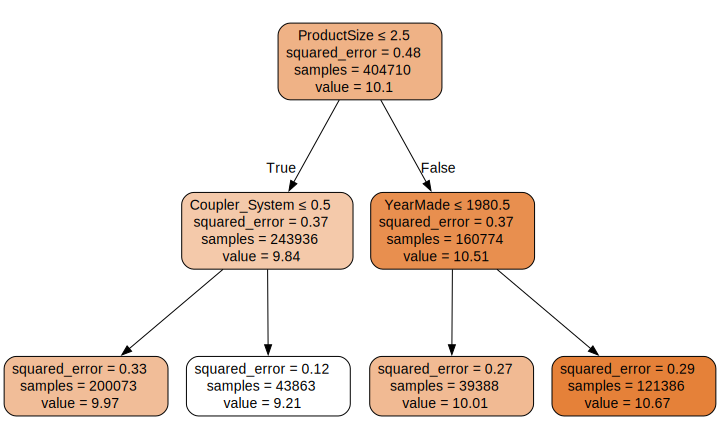

In [60]:
draw_tree(model, Xs, size=10)

Nút ở trên cùng đại diện cho mô hình ban đầu, chưa có phân chia nào cả, toàn bộ dữ liệu nằm trong một nhóm với kích thước là 395371, tức là toàn bộ tập dữ liệu. Ở bước này, mô hình chưa làm gì cả và luôn dự đoán giá trị là trung bình của toàn bộ tập dữ liệu, với sai số bình phương trung bình (mean squared error) là 0.48.

Khi đi xuống nhánh bên trái, đó là các bản ghi có `ProductSize` nhỏ hơn 2.5, còn nhánh bên phải là các bản ghi có `ProductSize` lớn hơn hoặc bằng 2.5, và cứ tiếp tục như vậy.

Bạn có thể thấy thuật toán cây quyết định (decision tree) của chúng ta đã tìm được cách chia nhị phân duy nhất để tách biệt các giá trị cao và thấp của giá đấu (auction price). Nút bên trái có `SalePrice` thấp hơn so với nút bên phải.

Dưới đây là một cách khác để biểu diễn cây của chúng ta.

/home/monarch/workplace/nhom12/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


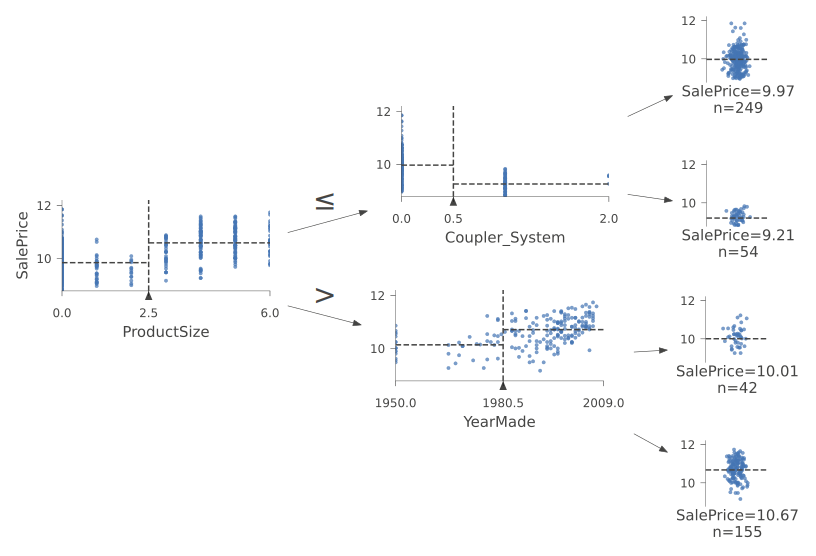

In [61]:
samp_idx = np.random.permutation(len(y))[:500]
viz_model = dtreeviz.model(model, X_train=Xs.iloc[samp_idx], y_train=y.iloc[samp_idx],
                           feature_names=Xs.columns, target_name=dep_var, )
viz_model.view(scale=2, fontname='DejaVu Sans', label_fontsize=10, orientation='LR')

biều đồ này cho chúng ta thấy được sự phân bổ của dữ liệu tại mỗi điềm chia

In [62]:
def m_rmse(m, xs, y): return rmse(m.predict(xs), y)

In [63]:
model = DecisionTreeRegressor(min_samples_leaf=25)
model.fit(Xs, y)
m_rmse(model, Xs, y), m_rmse(model, val_Xs, val_y)

(0.21085574376445976, 0.2628164012625059)

In [64]:
model.get_n_leaves()

np.int64(12434)

## Random forest

In [65]:
model = RandomForestRegressor(n_estimators=30, max_samples=200_000, max_features=0.5, 
                              min_samples_leaf=10, oob_score=True, n_jobs=-1).fit(Xs, y)

In [66]:
m_rmse(model, Xs,y), m_rmse(model, val_Xs, val_y)

(0.19388963779470855, 0.23823732869880265)

In [67]:
preds = np.stack([t.predict(val_Xs.values) for t in model.estimators_])
preds

array([[ 9.98790352, 10.0608179 ,  9.44686326, ...,  9.29822881,
         9.08766401,  9.08766401],
       [10.03167075,  9.99703132,  9.23409695, ...,  9.48857654,
         9.19960183,  9.19960183],
       [10.21756223, 10.08946112,  9.36482237, ...,  9.6594605 ,
         9.34955026,  9.34955026],
       ...,
       [ 9.7878227 ,  9.94758795,  9.40101872, ...,  9.24016305,
         9.41753561,  9.41753561],
       [10.03944784, 10.02514488,  9.42872924, ...,  9.69056055,
         9.29984189,  9.29984189],
       [ 9.88226112, 10.11427543,  9.25757019, ...,  9.39367274,
         9.25545216,  9.25545216]], shape=(30, 7988))

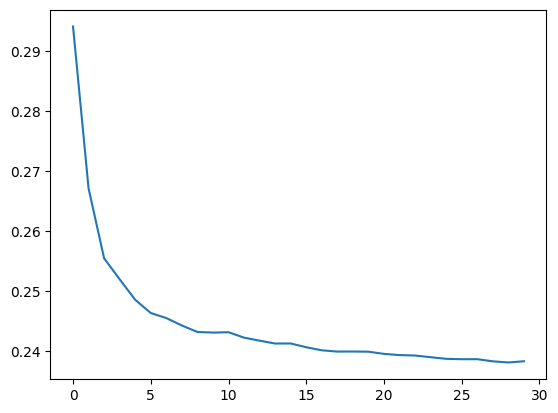

In [68]:
plt.plot([rmse(preds[:i+1].mean(axis=0), val_y) for i in range(30)])

In [69]:
rmse(model.oob_prediction_, y)

0.21791050490857872

In [70]:
preds.shape

(30, 7988)

Bây giờ chúng ta đã có tất cả cây quyết định và các phiên đấu giá trong tập validation, hãy kiểm tra sự biến động của dự đoán bằng cách xem xét độ lệch chuẩn (standard deviation) của chúng.

In [71]:
pred_std = preds.std(0)
pred_std[:10]

array([0.2434551 , 0.0783673 , 0.06322072, 0.24702088, 0.10477063,
       0.15699852, 0.29989002, 0.30255429, 0.29019388, 0.36241769])

Độ tin cậy trong dự đoán thay đổi khá lớn, ở một số phiên đấu giá, độ lệch chuẩn thấp vì các cây đồng thuận với nhau. Còn ở các phiên khác, độ lệch chuẩn cao hơn vì các cây bất đồng ý kiến, mỗi cây đều có quan điểm riêng của mình.

Chúng ta cũng muốn hiểu cách mà mô hình đưa ra dự đoán. Việc xem xét feature importance sẽ giúp chúng ta có cái nhìn sâu hơn về điều này.

In [72]:
model.feature_importances_

array([2.39295623e-02, 1.63655038e-02, 3.55961640e-02, 7.32689267e-04,
       1.63665729e-03, 1.95507203e-01, 1.31559643e-03, 6.79436274e-04,
       3.95782331e-02, 4.12591482e-02, 5.54064499e-02, 3.38963524e-03,
       1.44455399e-02, 1.96329692e-01, 5.65656125e-02, 2.90823249e-03,
       1.27140615e-02, 1.11082172e-02, 7.52538126e-03, 1.40747173e-02,
       3.31572882e-04, 1.06585054e-04, 7.01272247e-04, 1.30659831e-03,
       2.21080102e-03, 6.09596384e-04, 2.30797833e-03, 3.35987474e-03,
       3.89753009e-03, 6.85942836e-02, 5.57145853e-02, 2.62897085e-02,
       2.90886117e-03, 1.24030594e-03, 1.47810187e-03, 1.45668378e-04,
       3.20977428e-04, 9.93059658e-04, 7.65756414e-04, 2.58455837e-04,
       2.81969006e-04, 4.63983436e-03, 1.64573859e-03, 9.48189074e-03,
       1.94028852e-02, 9.42265685e-04, 2.43493411e-03, 2.20675411e-03,
       1.17917707e-03, 3.39474774e-03, 3.22095655e-06, 2.34580190e-06,
       3.14344194e-07, 3.18287851e-07, 0.00000000e+00, 0.00000000e+00,
      

In [73]:
fi = pd.DataFrame({'cols': Xs.columns, 'feat_imp': model.feature_importances_}).sort_values('feat_imp', ascending=False)
fi[:10]

,cols,feat_imp
13,ProductSize,0.196330
5,YearMade,0.195507
29,Coupler_System,0.068594
14,fiProductClassDesc,0.056566
30,Grouser_Tracks,0.055715
10,fiSecondaryDesc,0.055406
56,saleElapsed,0.047157
9,fiBaseModel,0.041259
8,fiModelDesc,0.039578
2,ModelID,0.035596


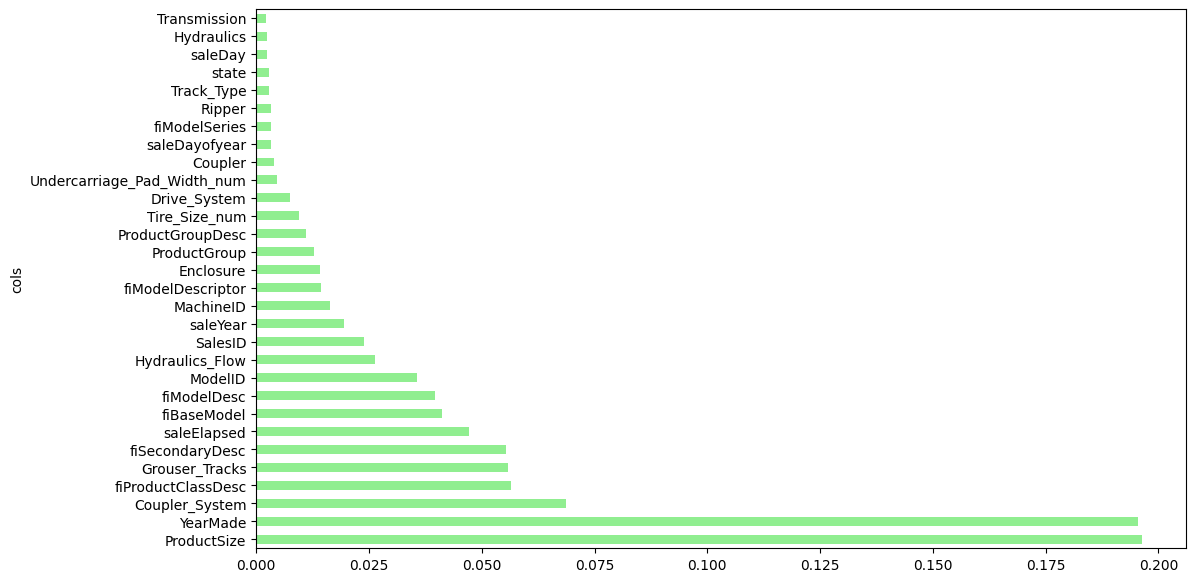

In [74]:
fi[:30].plot(x='cols', y='feat_imp' , kind='barh', color='lightgreen', figsize=(12, 7), legend=False); plt.show()

In [75]:
keeps = fi[fi['feat_imp']>0.005].cols
len(keeps)

20

In [76]:
Xs_imp = Xs[keeps]
val_Xs_imp = val_Xs[keeps]

In [77]:
model = RandomForestRegressor(n_estimators=30, max_samples=200_000, max_features=0.5, 
                              min_samples_leaf=10, oob_score=True, n_jobs=-1).fit(Xs_imp, y)

In [78]:
m_rmse(model, Xs_imp, y), m_rmse(model, val_Xs_imp, val_y)

(0.20053155201011297, 0.23575518891394298)

Lỗi nhìn chung là giống nhau, nhưng chúng ta có ít cột hơn để làm việc

In [79]:
len(Xs.columns), len(Xs_imp.columns)

(60, 20)

Khi xem xét tập dữ liệu, mình nhận thấy có một số biến dường như có ý nghĩa rất giống nhau. Hãy thử loại bỏ bất kỳ đặc trưng (feature) nào bị trùng lặp hoặc không cần thiết

Chúng ta thường sử dụng hệ số tương quan Pearson để đo lường mối quan hệ tuyến tính giữa các biến. Tuy nhiên, Pearson chỉ thật sự hiệu quả khi bạn có dữ liệu liên tục cho cặp biến và mối quan hệ giữa chúng tuân theo đường thẳng. Dữ liệu của chúng ta không đáp ứng những yêu cầu này, vì vậy đã đến lúc tìm một phương pháp đo lường tương quan khác.

"Spearman Correlation thích hợp hơn cho nhiều kiểu quan hệ khác nhau và dữ liệu của chúng ta cần đáp ứng một số yêu cầu:

1. Dữ liệu cần liên tục và tuân theo một mối quan hệ đơn điệu (monotonic relationship) hoặc dữ liệu dạng thứ bậc (ordinal data).
2. Quan hệ đơn điệu (monotonic relationship) có nghĩa là khi một biến tăng, biến kia có xu hướng hoặc tăng hoặc giảm, nhưng không nhất thiết phải theo đường thẳng.

Spearman Correlation là lựa chọn tuyệt vời cho dữ liệu thứ bậc (ordinal data). Phương pháp này hoạt động bằng cách chuyển đổi giá trị của mỗi biến thành thứ hạng (rank) và sau đó tính hệ số tương quan Pearson trên những giá trị đã được xếp hạng này. Vì vậy, nó phù hợp với dữ liệu thứ bậc và ít nhạy cảm hơn với phân phối thực của dữ liệu.

Cách hoạt động của Spearman Correlation:

1. Xếp hạng (Ranking): Với mỗi biến trong hai biến được so sánh, các giá trị được thay thế bằng thứ hạng của chúng.
   - Ví dụ: Nếu biến A có giá trị [10, 30, 20], thứ hạng của nó là [1, 3, 2].
   - Nếu biến B có giá trị [500, 200, 800], thứ hạng của nó là [2, 1, 3].

2. Tính Pearson trên thứ hạng (Pearson on Ranks): Sau khi chuyển đổi cả hai biến thành thứ hạng, hệ số tương quan Pearson được tính trên những giá trị được xếp hạng này."

Đầu tiên, chúng ta sẽ tính ma trận tương quan Spearman

In [80]:
corr_matrix_spearman = Xs_imp.corr(method='spearman')

Tiếp theo, chúng ta sẽ chuyển đổi ma trận tương quan thành ma trận khoảng cách. Công thức được sử dụng là `1 - abs(correlation)`. Điều này có nghĩa là:

- Các đặc trưng có tương quan cao (gần 1 hoặc -1) sẽ có khoảng cách nhỏ (gần 0).
- Các đặc trưng không có tương quan (gần 0) sẽ có khoảng cách lớn hơn (gần 1).

Chúng ta không quan tâm đến hướng của mối quan hệ (dương hay âm), mà chỉ quan tâm đến độ mạnh của mối quan hệ, vì vậy chúng ta sử dụng `abs`.

In [81]:
distance_matrix = 1 - np.abs(corr_matrix_spearman)
distance_matrix.shape

(20, 20)

Hàm `linkage` từ thư viện `scipy` yêu cầu một ma trận khoảng cách dạng nén (condensed distance matrix), tức là một mảng 1D biểu diễn phần tam giác phía trên của ma trận khoảng cách. Tuy nhiên, `distance_matrix` của chúng ta hiện đang ở dạng vuông (nxn). Vì vậy, chúng ta cần chuyển đổi nó thành dạng nén bằng phương pháp `squareform`.

Phương pháp `squareform` sẽ chuyển đổi một vector khoảng cách dạng vector-form thành ma trận khoảng cách dạng vuông, và ngược lại.

In [82]:
condensed_distance_matrix = hc.distance.squareform(distance_matrix, checks=False)

Chúng ta sử dụng phương pháp 'average' ở đây, phương pháp này tính khoảng cách trung bình giữa tất cả các quan sát trong hai tập hợp.

In [83]:
linkage_matrix = hc.linkage(condensed_distance_matrix, method='average')

ve bieu do dendrogram

Text(0, 0.5, 'Features')

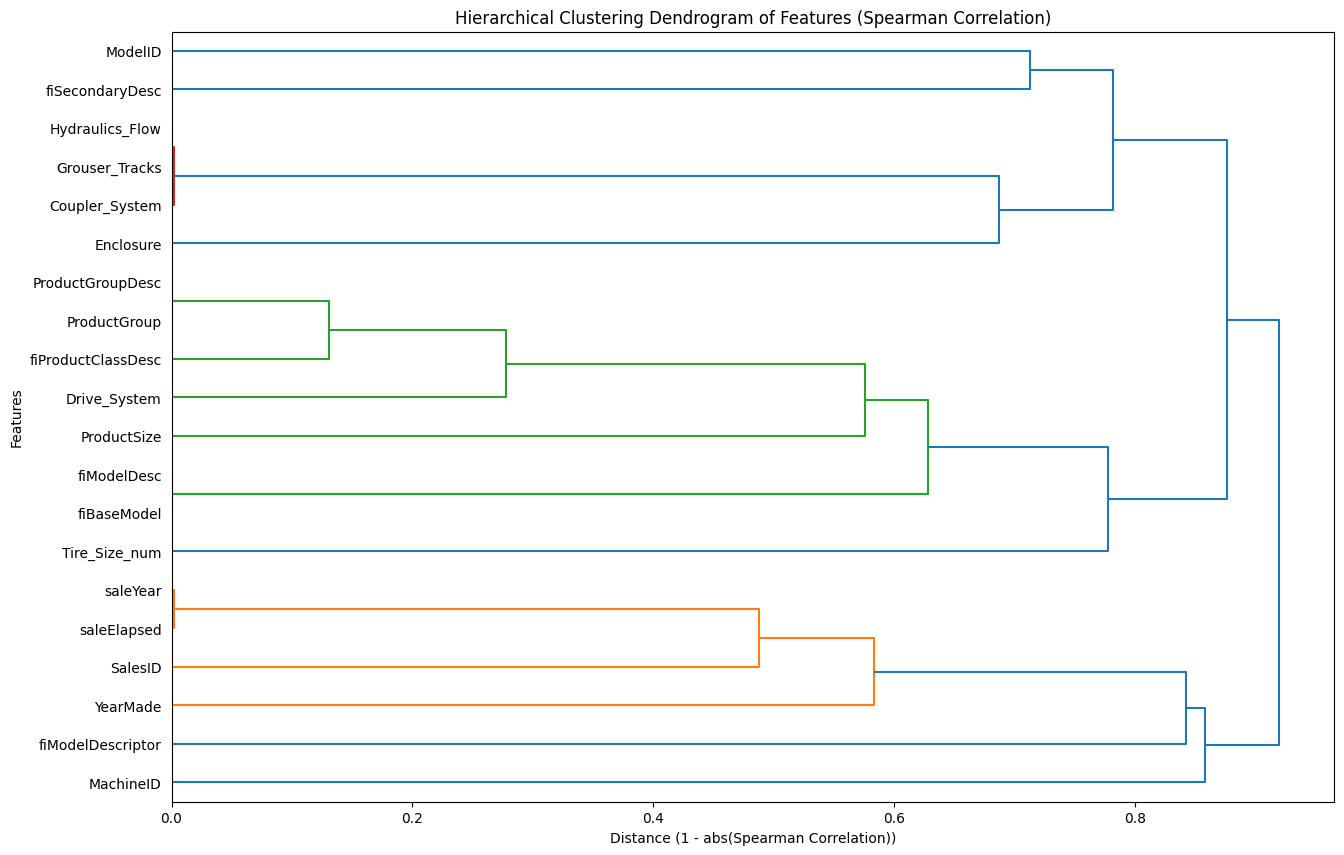

In [84]:
plt.figure(figsize=(15, 10))
hc.dendrogram(linkage_matrix, labels=Xs_imp.columns.tolist(), orientation='right', 
                           leaf_rotation=0, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram of Features (Spearman Correlation)')
plt.xlabel('Distance (1 - abs(Spearman Correlation))')
plt.ylabel('Features')

Những cặp cột có mức độ tương đồng cao nhất là những cột được gộp lại với nhau sớm. Không có gì ngạc nhiên khi các cặp như `ProductGroup` và `ProductGroupDesc`, `saleYear` và `saleElapsed`, `fiModelDesc` và `fiBaseModel` được gộp lại khá sớm, điều này cho thấy chúng có thể có mối tương quan cao.

Vậy chúng ta sẽ lần lượt loại bỏ từng đặc trưng tương tự để xem liệu mô hình có thể được đơn giản hóa mà không ảnh hưởng đến độ chính xác hay không. Chúng ta sẽ tạo một hàm nhanh chóng huấn luyện mô hình Random Forest và trả về điểm OOB (Out-of-Bag).

Để tăng tốc độ huấn luyện, chúng ta sẽ sử dụng các giá trị sau 
- Giảm `max_samples`: Chỉ sử dụng một phần nhỏ của dữ liệu cho mỗi cây trong rừng.
- Tăng `min_samples_leaf`: Đảm bảo mỗi lá trong cây có số mẫu tối thiểu cao hơn.

In [85]:
def get_oob(X ,y):
    rf = RandomForestRegressor(n_estimators=30, min_samples_leaf=15, max_samples=50000,
                                max_features=0.5, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    return rf.oob_score_

Đây là mô hình cơ sở của chúng ta khi chưa loại bỏ bất kỳ đặc trưng nào.

In [86]:
get_oob(Xs_imp, y)

0.8770511706117246

Giờ chúng ta sẽ lần lượt loại bỏ từng đặc trưng dư thừa để kiểm tra xem mô hình có thể được đơn giản hóa mà không ảnh hưởng đến hiệu suất hay không.

In [87]:
{col: get_oob(Xs_imp.drop(col, axis=1), y) for col in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup', 'fiModelDesc', 
    'fiBaseModel', 'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System'
)}

{'saleYear': 0.8757557695096799,
 'saleElapsed': 0.8718707891155009,
 'ProductGroupDesc': 0.8765892174384766,
 'ProductGroup': 0.8772677735797422,
 'fiModelDesc': 0.8751931549682397,
 'fiBaseModel': 0.8761208775058392,
 'Hydraulics_Flow': 0.8765549911816721,
 'Grouser_Tracks': 0.8771148645692347,
 'Coupler_System': 0.8763982895942696}

In [88]:
to_drops = ['Hydraulics_Flow', 'Grouser_Tracks', 'ProductGroupDesc', 'saleYear', 'fiBaseModel']
get_oob(Xs_imp.drop(to_drops, axis=1), y)

0.8739568081639246

In [89]:
Xs_final = Xs_imp.drop(to_drops, axis=1)
val_Xs_final = val_Xs_imp.drop(to_drops, axis=1)

In [90]:
Xs_final.columns

Index(['ProductSize', 'YearMade', 'Coupler_System', 'fiProductClassDesc',
       'fiSecondaryDesc', 'saleElapsed', 'fiModelDesc', 'ModelID', 'SalesID',
       'MachineID', 'fiModelDescriptor', 'Enclosure', 'ProductGroup',
       'Tire_Size_num', 'Drive_System'],
      dtype='object')

In [91]:
with open('../data/Xs_final.pkl', 'wb') as f:
    pickle.dump(Xs_final, f)

with open('../data/val_Xs_final.pkl', 'wb') as f:
    pickle.dump(val_Xs_final, f)

In [92]:
with open('../data/Xs_final.pkl', 'rb') as f:
    Xs_final = pickle.load(f)
    
with open('../data/val_Xs_final.pkl', 'rb') as f:
    val_Xs_final = pickle.load(f)

## Extrapolation problem

Giống như các thuật toán học máy khác, Random Forest không phải lúc nào cũng tổng quát hóa tốt với dữ liệu mới. Hãy xem xét ví dụ này với 40 điểm dữ liệu. Chúng ta sẽ huấn luyện mô hình bằng 30 điểm dữ liệu đầu tiên và kiểm tra hiệu suất của nó trên 10 điểm dữ liệu cuối cùng.

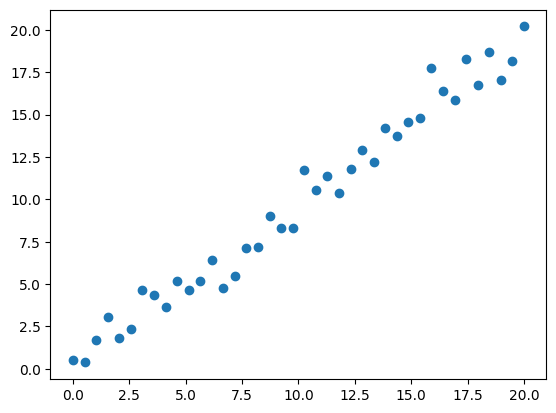

In [93]:
np.random.seed(42)
x_lin = np.linspace(0, 20, 40)
y_lin = x_lin + np.random.randn(len(x_lin))
plt.scatter(x_lin, y_lin);

In [94]:
x_lin = x_lin[:,None]
m_lin = RandomForestRegressor().fit(x_lin[:30], y_lin[:30])

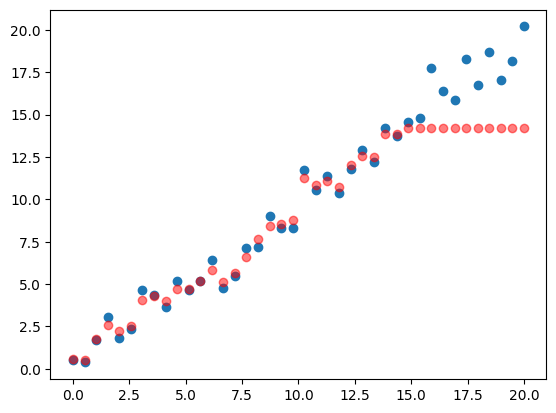

In [95]:
plt.scatter(x_lin, y_lin);
plt.scatter(x_lin, m_lin.predict(x_lin), color='red', alpha=0.5);

dự đoán của chúng ta cho các dữ liệu nằm ngoài phạm vi được sử dụng để huấn luyện mô hình là kém. Tại sao lại như vậy?

Random Forest chỉ đơn giản là trung bình của các dự đoán từ các cây quyết định riêng lẻ. Một cây dự đoán giá trị trung bình của các hàng trong một lá (leaf). Dự đoán cho một điểm dữ liệu mới được xác định bởi các giá trị của các mẫu huấn luyện nằm trong nút lá mà điểm dữ liệu mới rơi vào. Vì vậy, nếu bạn cung cấp cho mô hình một điểm dữ liệu mới với tổ hợp giá trị đặc trưng khác biệt đáng kể so với bất kỳ điều gì nó đã thấy trong quá trình huấn luyện, mô hình sẽ không có kinh nghiệm trực tiếp để dự đoán cho loại dữ liệu mới này.

Ví dụ, trong tập kiểm định của chúng ta có thể xuất hiện các giá trị danh mục mới hoặc các giá trị nằm ngoài phạm vi được quan sát cho một đặc trưng trong quá trình huấn luyện. Điều này được gọi là dữ liệu ngoài miền (Out-Of-Domain - OOD).

Do đó, chúng ta cần đảm bảo rằng tập kiểm định không chứa dữ liệu OOD. Đôi khi khó để biết liệu tập kiểm định có phân phối giống với tập huấn luyện hay không. Có một cách để kiểm tra điều này là sử dụng Random Forest để huấn luyện mô hình nhằm dự đoán xem một hàng thuộc vào tập kiểm định hay tập huấn luyện.

In [96]:
df_full = pd.concat([Xs_final, val_Xs_final])
is_valid = np.array([0]*len(Xs_final) + [1]*len(val_Xs_final))
model = RandomForestRegressor(n_estimators=40, max_samples=200_000, max_features=0.5, 
                              min_samples_leaf=10, oob_score=True, n_jobs=-1)
model.fit(df_full, is_valid)
pd.Series(model.feature_importances_, index=df_full.columns).sort_values(ascending=False)

saleElapsed           0.889047
SalesID               0.093762
MachineID             0.011731
YearMade              0.001393
ModelID               0.000958
fiModelDesc           0.000637
Enclosure             0.000604
fiProductClassDesc    0.000519
fiSecondaryDesc       0.000373
fiModelDescriptor     0.000357
Tire_Size_num         0.000242
Coupler_System        0.000178
ProductGroup          0.000135
ProductSize           0.000047
Drive_System          0.000018
dtype: float64

Điều này cho thấy rằng có 3 cột khác biệt đáng kể giữa tập huấn luyện và tập kiểm định: `saleElapsed`, `SalesID`, và `MachineID`. Điều này hợp lý vì `saleElapsed` được tạo bằng cách sử dụng `saledate`, vì vậy các giá trị trong tập kiểm định sẽ lớn hơn giá trị lớn nhất được thấy trong tập huấn luyện. `SalesID` mỗi giao dịch trong tập kiểm định sẽ có một ID mới, duy nhất, không xuất hiện trong tập huấn luyện. `MachineID` trong khi có thể một máy được bán trong giai đoạn huấn luyện có thể được bán lại trong giai đoạn kiểm định, nhưng phần lớn các ID máy trong tập kiểm định sẽ là mới.

Giờ chúng ta sẽ lần lượt loại bỏ từng cột này để xem ảnh hưởng của chúng đến hiệu suất mô hình.

In [97]:
def rf(Xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, 
       min_samples_leaf=5, **kwargs):
    m = RandomForestRegressor(n_estimators=n_estimators, max_samples=max_samples, max_features=max_features,
                                   min_samples_leaf=min_samples_leaf, oob_score=True, n_jobs=-1, **kwargs).fit(Xs, y)
    return m

In [98]:
model = rf(Xs_final, y)
print('original', m_rmse(model, val_Xs_final, val_y))
for col in ('SalesID', 'saleElapsed', 'MachineID'):
    m = rf(Xs_final.drop(col, axis=1), y)
    print(col, m_rmse(m, val_Xs_final.drop(col, axis=1), val_y))

original 0.23216558321087877
SalesID 0.2298556885324074
saleElapsed 0.2343878605629048
MachineID 0.23002106141308962


Việc loại bỏ `SalesID` và `MachineID` đã cải thiện hiệu suất của mô hình.

In [99]:
ood_cols = ['SalesID', 'MachineID']
Xs_final_v2 = Xs_final.drop(ood_cols, axis=1)
val_Xs_final_v2 = val_Xs_final.drop(ood_cols, axis=1)

model = rf(Xs_final_v2, y)
m_rmse(model, val_Xs_final_v2, val_y)

0.22948262265946856

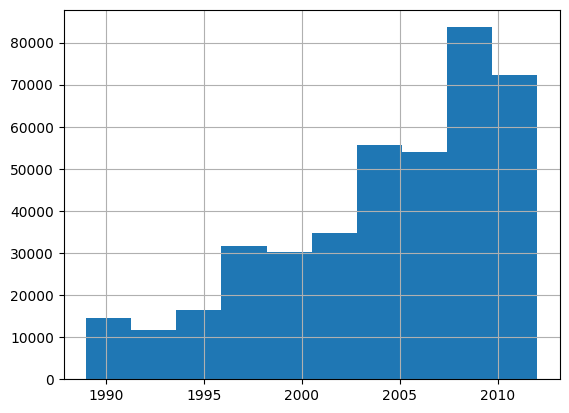

In [100]:
Xs['saleYear'].hist();

Một điều có thể hữu ích trong trường hợp của chúng ta là không sử dụng dữ liệu cũ, khi làm việc với các bài toán chuỗi thời gian, dữ liệu cũ cho thấy các mối quan hệ không còn hợp lệ nữa

In [101]:
cond = Xs['saleYear']>2003
Xs_final_v3 = Xs_final_v2[cond]
y_final = y[cond]

In [102]:
model = rf(Xs_final_v3, y_final)
m_rmse(model, Xs_final_v3, y_final), m_rmse(model, val_Xs_final_v2, val_y)

(0.17982175185253774, 0.2294663644721288)

slightly better

In [103]:
Xs_final_v3.shape

(250023, 13)

In [104]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)